-------------------------------------------------------------------------------------------
ScatterData_Kaladonger_KD29.csv


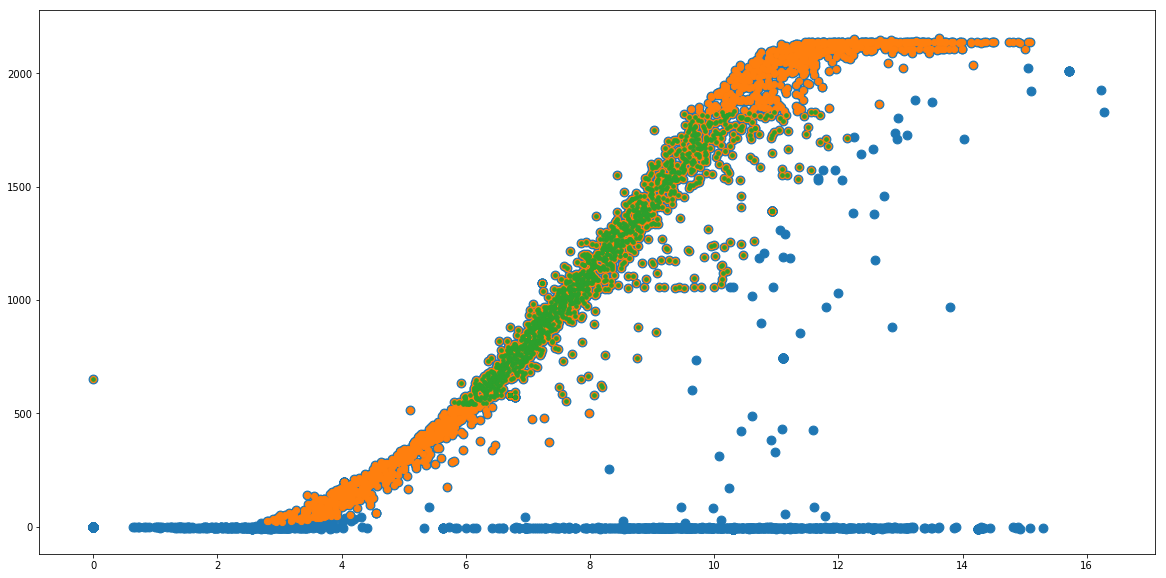

0.367869939635
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
ScatterData_Kaladonger_KD07.csv


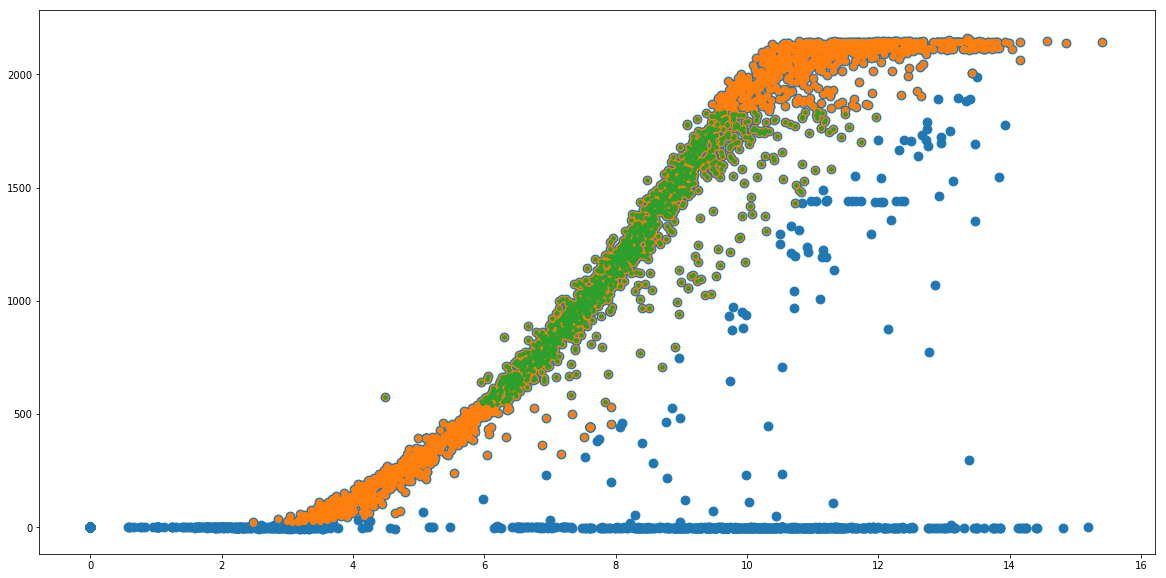

0.374996570752
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
ScatterData_Mokal_MK066.csv


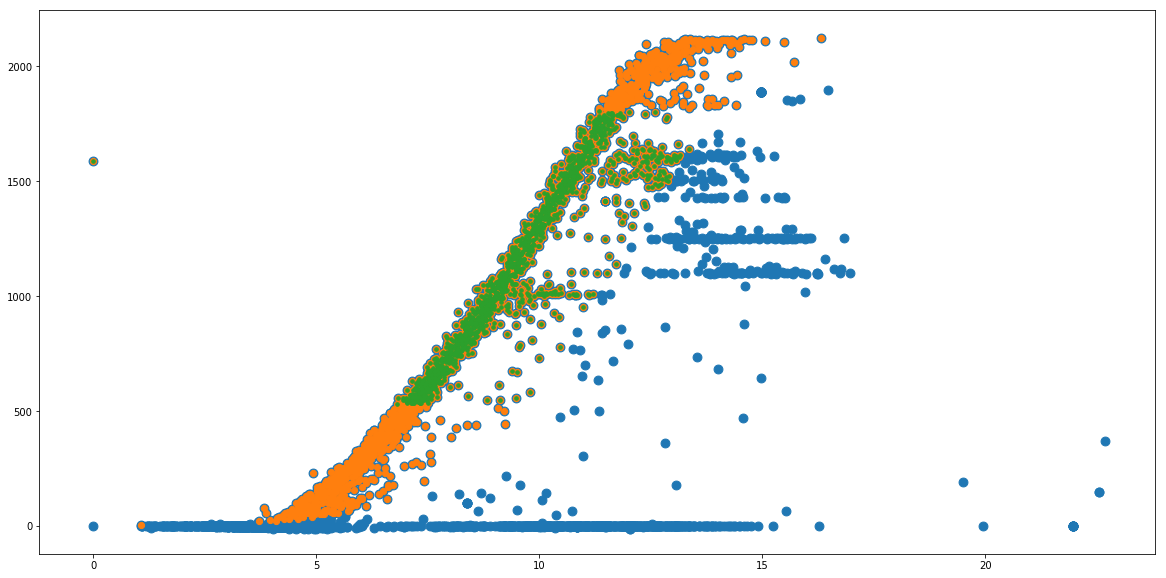

0.3665766231
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
ScatterData_Mokal_MK014.csv


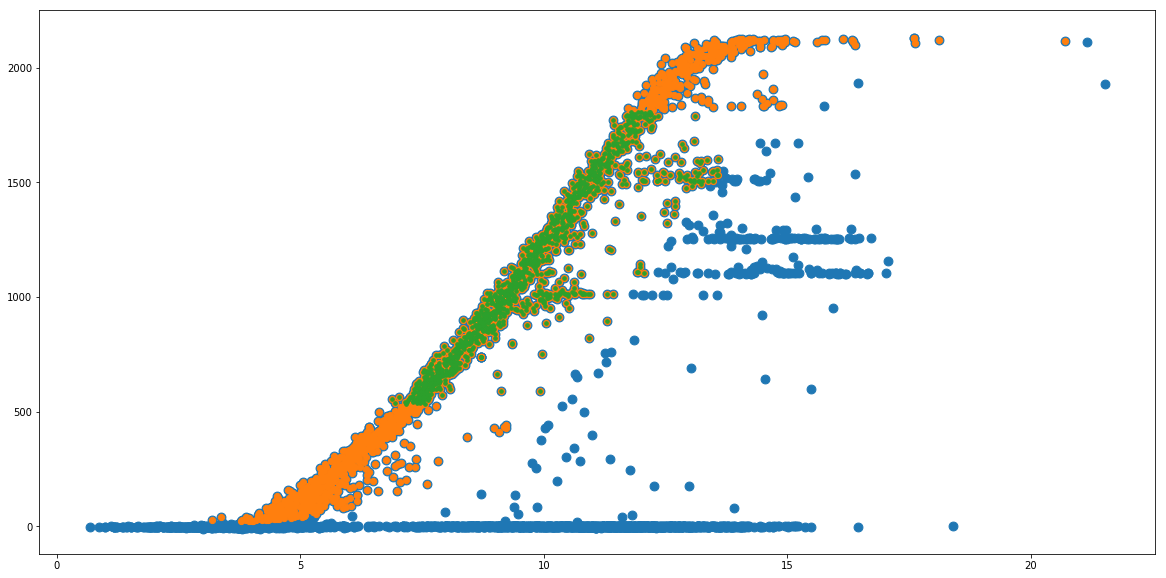

0.368331205896
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
ScatterData_Nidhi_NDH-047.csv


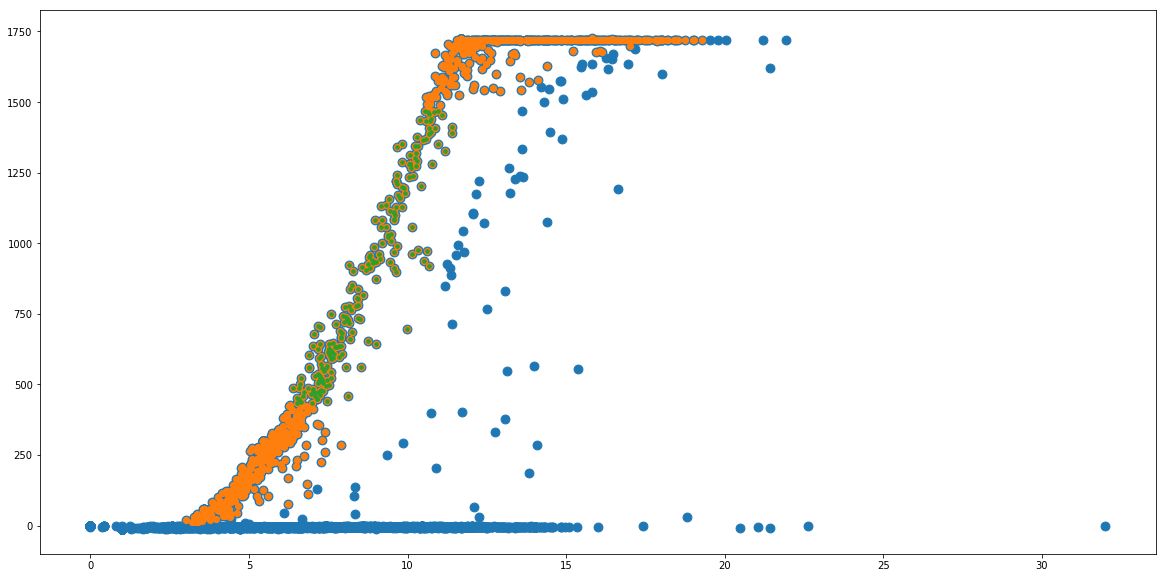

0.378962096347
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
ScatterData_Mahidad_JSD38.csv


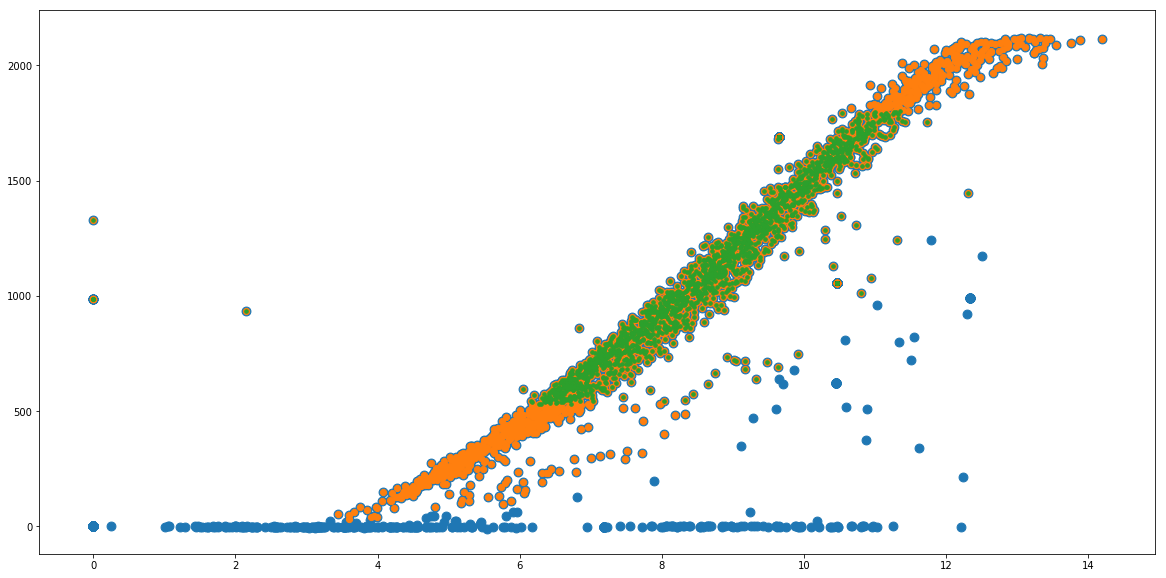

0.375259629334
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
ScatterData_Pottipadu_PPD01.csv


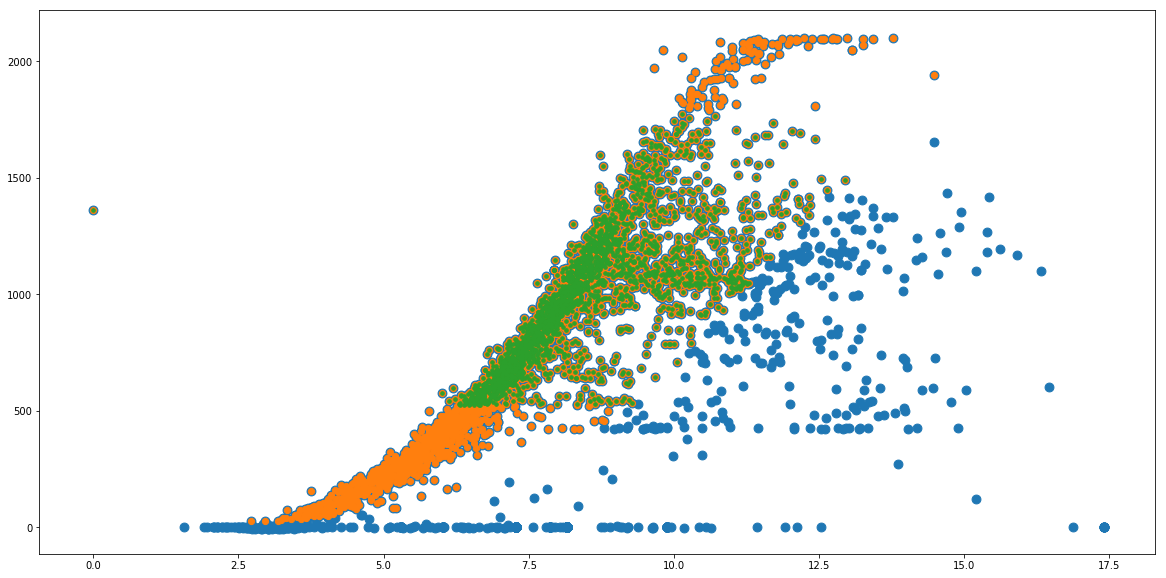

0.327716188783
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
refcrv_testing.csv


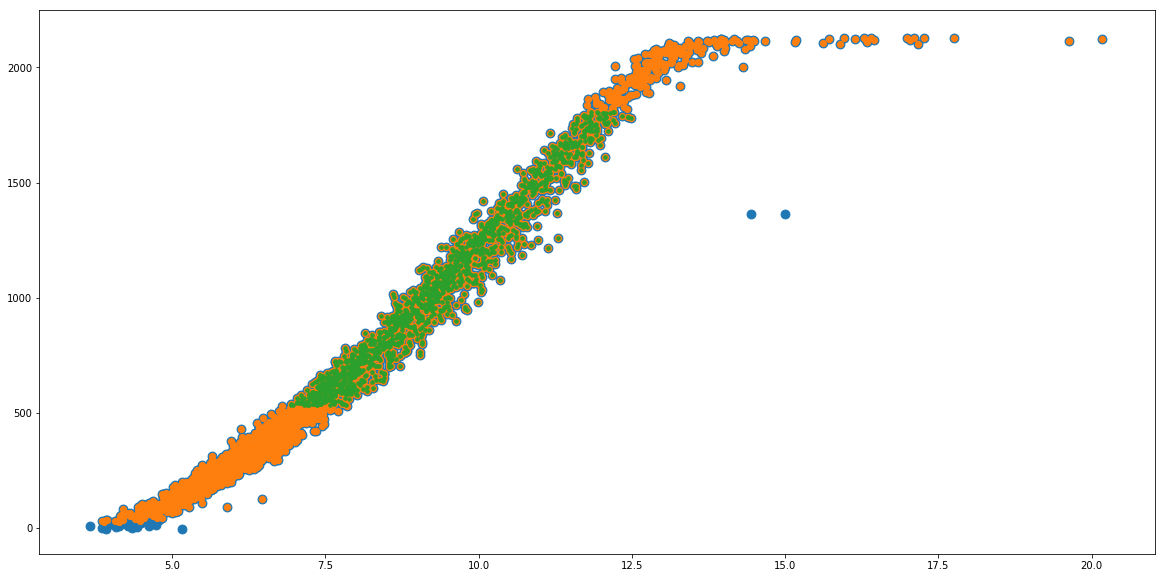

0.386940028425
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
ScatterData_Nidhi_NDH-022.csv


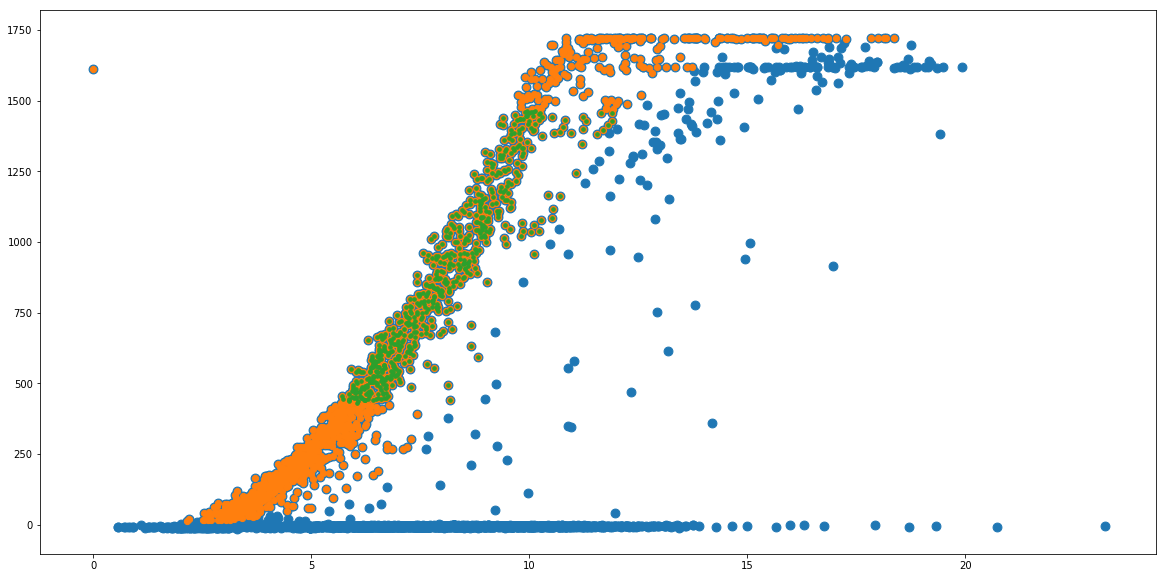

0.367466728393
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
ScatterData_Chakla_C66.csv


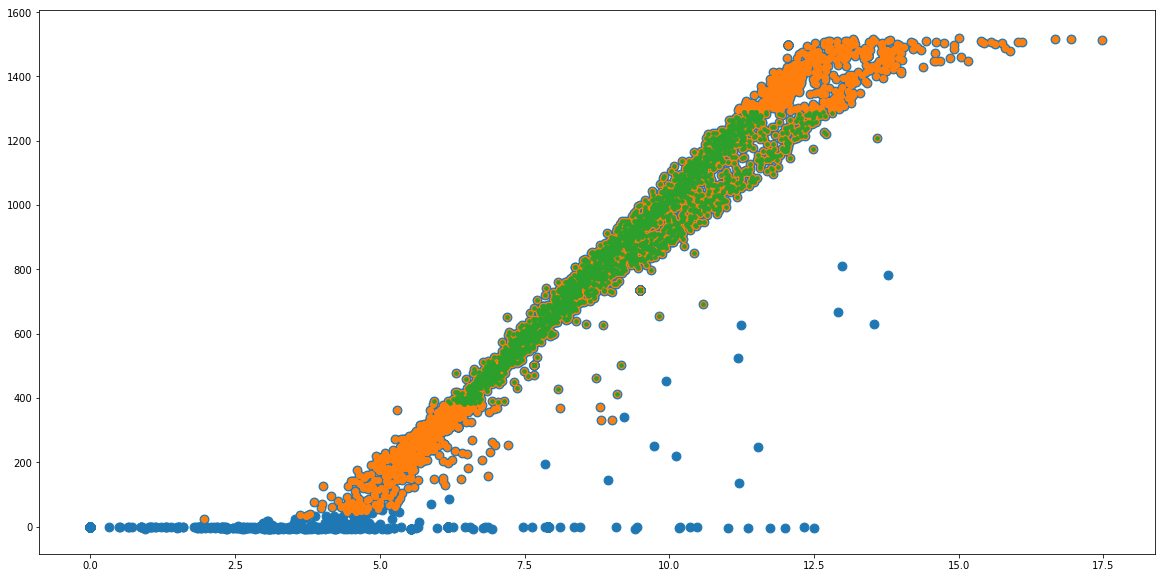

0.375468733607
-------------------------------------------------------------------------------------------


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.cluster import *


def process_dbscan(data_set, dict_params_dbscan, scale_factor_wind_speed=4.0/3, scale_factor_active_power=1):

    # Only take the required data, only positive power points
    required_data = data_set[data_set['ActivePower'] > 0.08][['ActivePower', 'WindSpeed', 'Timestamp']].copy()

    # Get some params
    max_wind_speed = required_data['WindSpeed'].max()
    min_wind_speed = required_data['WindSpeed'].min()
    max_active_power = required_data['ActivePower'].max()
    min_active_power = required_data['ActivePower'].min()
    normalization_factor_wind_speed = max_wind_speed - min_wind_speed
    normalization_factor_active_power = max_active_power - min_active_power

    # Add some columns to required data
    required_data['ScaledWindSpeed'] = ((required_data['WindSpeed'] - min_wind_speed) * scale_factor_wind_speed) \
                                        / normalization_factor_wind_speed
    required_data['ScaledActivePower'] = ((required_data['ActivePower'] - min_active_power) * scale_factor_active_power) \
                                        / normalization_factor_active_power
    
    # Cluster default Number
    required_data['cluster_number'] = -2
    
    # Clustring Algorithm
    clustering_algorithm = DBSCAN(**dict_params_dbscan)
    
    # run the algorithm
    required_data['cluster_number'] = clustering_algorithm.fit_predict(required_data[['ScaledWindSpeed', \
                                                                                      'ScaledActivePower']])

    return required_data.copy()
    
def curve_filter(data_set, return_columns, push_down_value, curve_straighten_value, push_right_value):

    # Find the cluster with max number of elements
    max_elements_cluster_number = -2
    max_elements = 0
    for group in data_set.groupby('cluster_number'):
        if(group[1].shape[0] > max_elements):
            max_elements = group[1].shape[0]
            max_elements_cluster_number = group[0]

    
    # define limits
    scales_active_power_limits = (0.03, 0.97)
    
    # Apply some filters to get the required
    global_high_cluster = data_set[data_set['ScaledActivePower'] > 0.99]   
    max_elements_cluster = data_set[data_set['cluster_number'] == max_elements_cluster_number]
    filter_limits_active_power = max_elements_cluster[ \
                                    (max_elements_cluster['ScaledActivePower'] > scales_active_power_limits[0]) \
                                     & (max_elements_cluster['ScaledActivePower'] < scales_active_power_limits[1])]


    # Customised Sigmoid function for curve fitting
    def custom_sigmoid(x, a, b):
        return 1/(1 + np.exp(-a * x + b))
    
    optimize_on = pd.concat([filter_limits_active_power, global_high_cluster])
    
    params_optimal, params_covariance = curve_fit(custom_sigmoid, optimize_on['ScaledWindSpeed'], \
                                                  optimize_on['ScaledActivePower'])
    
    ################################### Filter elements below the Curve ############################
    filtered_data = data_set[data_set['ScaledActivePower'] > (custom_sigmoid(data_set['ScaledWindSpeed'], \
                                                                        params_optimal[0] + curve_straighten_value, \
                                                                        params_optimal[1] + push_right_value) \
                                                                        - push_down_value)]
    
    points_above_the_curve = filtered_data[return_columns].copy()
    
    return points_above_the_curve


from os import listdir
from os.path import isfile, join

data_path = '/home/mytrah-pc/Mytrah_Adithya/data_turbine/'
for f in listdir(data_path):


    data_set = pd.read_csv(data_path + f)
    data_set.drop_duplicates(subset=['ActivePower', 'WindSpeed'], keep=False)

    points_above_curve = curve_filter(
        process_dbscan(
            data_set=data_set,
            dict_params_dbscan={
                'eps': 0.3/20,
                'min_samples': 15
            },
            scale_factor_wind_speed=4.0/3,
            scale_factor_active_power=1
        ),
        return_columns=['ActivePower', 'WindSpeed', 'Timestamp', 'ScaledActivePower'],
        push_down_value=0,
        curve_straighten_value=0,
        push_right_value=1.5
    )

    work_data = points_above_curve[(points_above_curve['ScaledActivePower'] > 0.25) & (points_above_curve['ScaledActivePower'] < 0.85)].copy()

    def rounding_method(number):
        multiply_factor = 100
        int_format = int(number * multiply_factor)
        round_off_by_factor = 2
        delta = int_format % round_off_by_factor
        return int_format + round_off_by_factor - delta

    work_data['trend_indexer'] = work_data['ScaledActivePower'].apply(rounding_method)

    import matplotlib.pyplot as plt
    from scipy.stats import norm

    hist = None
    mid = -10
    tot_scr = 0
    tot_ex = 0
    for group in work_data.groupby('trend_indexer'):
    #     plt.hist(group[1]['WindSpeed'])
    #     plt.show()
        hist = np.histogram(group[1]['WindSpeed'])
        mid = 0
        score = 0
        for i in range(hist[0].shape[0]):
            mid = mid + hist[0][i] * ((hist[1][i] + hist[1][i + 1]) / 2)
        #print (mid / hist[0].sum())
        for i in range(hist[0].shape[0]):
            score = score + norm((mid / hist[0].sum()), 1).pdf((hist[1][i] + hist[1][i + 1]) / 2) * hist[0][i]
        #print score / hist[0].sum()
        tot_scr = tot_scr + (score / hist[0].sum())
        tot_ex = tot_ex + 1
    
    plt.figure(figsize=(20, 10))
    plt.scatter(data_set['WindSpeed'], data_set['ActivePower'], s=np.pi*5*5) 
    plt.scatter(points_above_curve['WindSpeed'], points_above_curve['ActivePower'], s=np.pi*3.5*3.5)
    plt.scatter(work_data['WindSpeed'], work_data['ActivePower'], s=np.pi*2*2)

    print '-------------------------------------------------------------------------------------------'
    print f
    plt.show()
    print tot_scr / tot_ex
    print '-------------------------------------------------------------------------------------------'